In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import vaex

from matplotlib.lines import Line2D

sns.set(style='ticks', 
        rc={'font.family'          : 'serif',
            'text.usetex'          : True,
            'axes.axisbelow'       : True,
            'mathtext.fontset'     : 'cm',
            'mathtext.default'     : 'regular',
            'xtick.direction'      : 'in',
            'ytick.direction'      : 'in',
            'xtick.major.width'    : 1.1,
            'ytick.major.width'    : 1.1,
            'axes.labelpad'        : 5.0,
            'legend.framealpha'    : 0.95,
            'legend.handlelength'  : 1.2,
            'legend.handletextpad' : 0.5,
       })

pal = sns.color_palette('colorblind')
dark = sns.color_palette('dark')
sns.set_palette(pal)

In [2]:
def open_and_select(photfile='../legacy_phot/M33_full_unmatched.hdf5'):
    if type(photfile) == list:
        ds = vaex.open_many(photfile)
    else:
        ds = vaex.open(photfile)
    ds.select('(F275W_SNR > 4) & (F275W_SHARP**2 < 0.15)', name='F275W_ST')
    ds.select('(F275W_ST & (F275W_CROWD < 1.30))', name='F275W_GST')
    ds.select('(F336W_SNR > 4) & (F336W_SHARP**2 < 0.15)', name='F336W_ST')
    ds.select('F336W_ST & (F336W_CROWD < 1.30)', name='F336W_GST')
    ds.select('F275W_ST | F336W_ST', name='UV_ST')
    ds.select('F275W_GST & F336W_GST', name='UV_GST')

    ds.select('(F475W_SNR > 4) & (F475W_SHARP**2 < 0.2)', name='F475W_ST')
    ds.select('(F475W_ST & (F475W_CROWD < 2.25))', name='F475W_GST')
    ds.select('(F814W_SNR > 4) & (F814W_SHARP**2 < 0.2)', name='F814W_ST')
    ds.select('F814W_ST & (F814W_CROWD < 2.25)', name='F814W_GST')
    ds.select('F475W_ST | F814W_ST', name='OPT_ST')
    ds.select('F475W_GST & F814W_GST', name='OPT_GST')

    ds.select('(F110W_SNR > 4) & (F110W_SHARP**2 < 0.15)', name='F110W_ST')
    ds.select('F110W_ST & (F110W_CROWD < 2.25)', name='F110W_GST')
    ds.select('(F160W_SNR > 4) & (F160W_SHARP**2 < 0.15)', name='F160W_ST')
    ds.select('F160W_ST & (F160W_CROWD < 2.25)', name='F160W_GST')
    ds.select('F110W_ST | F160W_ST', name='IR_ST')
    ds.select('F110W_GST & F160W_GST', name='IR_GST')
    return ds

ds = open_and_select()
print(ds.length())

22549213


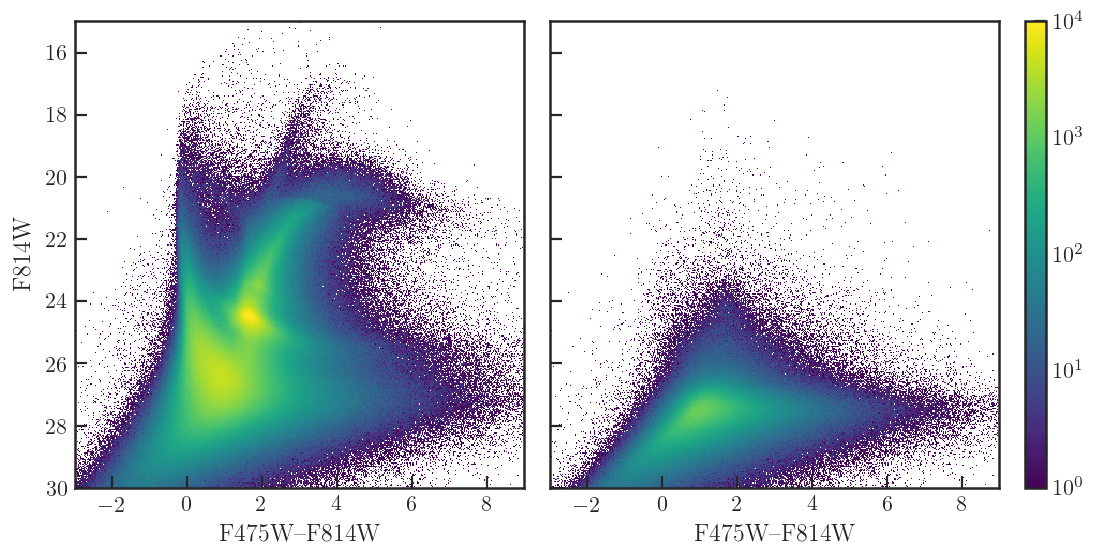

In [3]:
# W14 Fig 7

colormap, vmin, vmax = 'viridis', 1, 1e4
cmap = getattr(mpl.cm, colormap)
norm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax)

opt_lim = [[-3, 9], [30, 15]]

fig = plt.figure(figsize=(7.2, 4))
ds.plot('F475W_VEGA-F814W_VEGA', 'F814W_VEGA', limits=opt_lim,
        f='log10', colorbar=False, colormap=colormap,
        vmin=np.log10(vmin), vmax=np.log10(vmax), interpolation='None', shape=420,
        selection=[None, '~OPT_ST'], 
        visual=dict(column='selection'), xlabel='F475W--F814W', ylabel='F814W')
ax0, ax1 = fig.get_axes()
ax1.set_ylabel(None)
ax1.set_yticklabels([])
fig.tight_layout()

pos = ax1.get_position()
cax = fig.add_axes([pos.x1+0.025, pos.y0, 0.02, pos.height])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax)

fig.savefig('survey_paper_figures/F475W_F814W_full_cut_CMDs.pdf', dpi=420, bbox_inches='tight')

In [4]:
def add_colorbar(fig, ax, cmap='viridis', vmin=0, vmax=1, norm='Normalize'):
    # norm: mpl.colors
    pos = ax.get_position()
    cax = fig.add_axes([pos.x1+0.0175, pos.y0, 0.0225, pos.height])
    cmap_mpl = getattr(mpl.cm, cmap)
    norm_mpl = getattr(mpl.colors, norm)(vmin=vmin, vmax=vmax)
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm_mpl, cmap=cmap_mpl), cax=cax)
    return cbar

def plot_frac_density(ds, f_blue, f_red, lim, save=True,
                      cmap_dens='viridis', vmin_dens=1, vmax_dens=1e4,
                      cmap_frac='cividis_r', vmin_frac=0, vmax_frac=1):
    # W14 Fig 9
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(7.2, 3.6), sharex=True)
    plt.sca(ax0)
    
    plot_kwargs = dict(limits=lim, interpolation='None', shape=420,
                       xlabel=f'{f_blue}--{f_red}', ylabel=f'{f_red}',
                       colorbar=False)
    
    ds.plot(f'{f_blue}_VEGA-{f_red}_VEGA', f'{f_red}_VEGA',
            colormap=cmap_frac, vmin=vmin_frac, vmax=vmax_frac,
            what=f'mean({f_blue}_GST_FLAG * {f_red}_GST_FLAG)',
            **plot_kwargs)

    plt.sca(ax1)
    ds.plot(f'{f_blue}_VEGA-{f_red}_VEGA', f'{f_red}_VEGA',
            f='log10', colormap=cmap_dens,
            vmin=np.log10(vmin_dens), vmax=np.log10(vmax_dens),
            selection=f'{f_blue}_GST & {f_red}_GST',
            **plot_kwargs)
    
    ax1.set_ylabel(None)
    ax1.set_yticklabels([])
    fig.tight_layout(w_pad=6)
    
    cbar_frac = add_colorbar(fig, ax0, cmap=cmap_frac, vmin=vmin_frac, vmax=vmax_frac)
    cbar_dens = add_colorbar(fig, ax1, cmap=cmap_dens, vmin=vmin_dens, vmax=vmax_dens, norm='LogNorm')

    if save:
        fig.savefig(f'survey_paper_figures/{f_blue}_{f_red}_CMDs.pdf',
                    dpi=420, bbox_inches='tight')

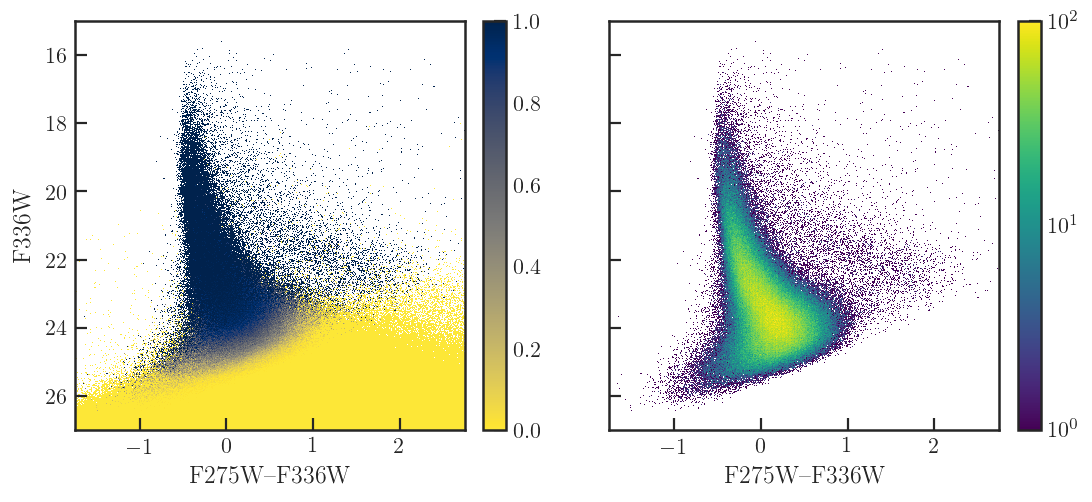

In [5]:
plot_frac_density(ds, 'F275W', 'F336W', [[-1.75, 2.75], [27, 15]], vmax_dens=1e2)

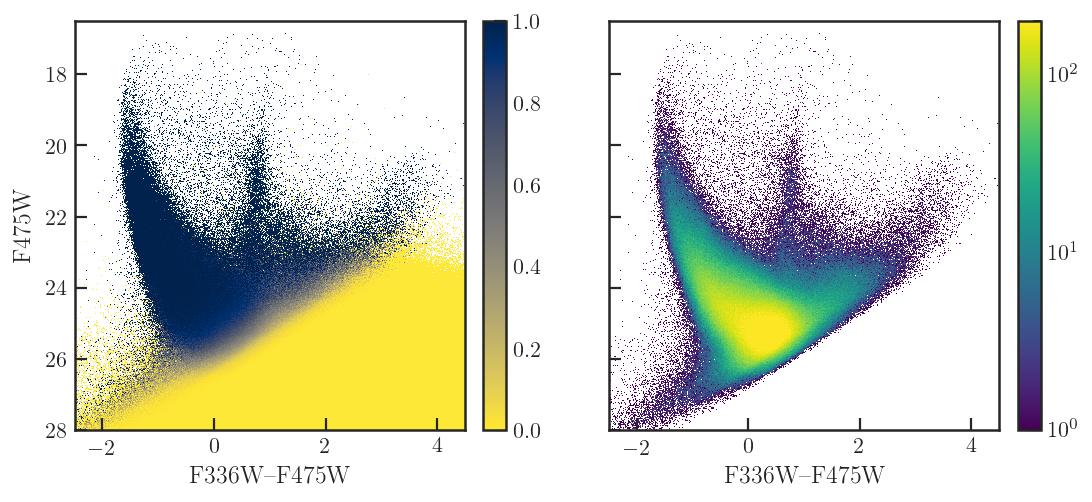

In [6]:
plot_frac_density(ds, 'F336W', 'F475W', [[-2.5, 4.5], [28, 16.5]], vmax_dens=2e2)

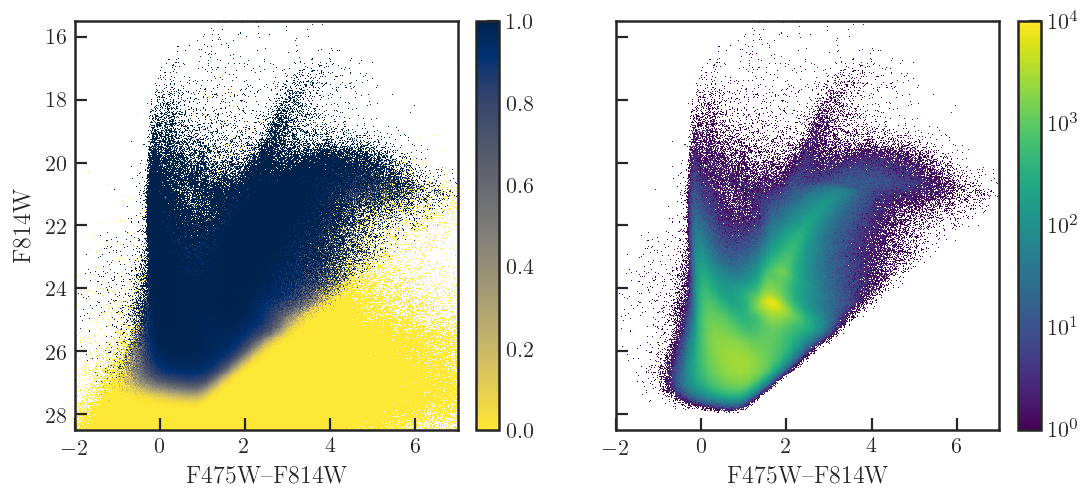

In [7]:
plot_frac_density(ds, 'F475W', 'F814W', [[-2, 7], [28.5, 15.5]])

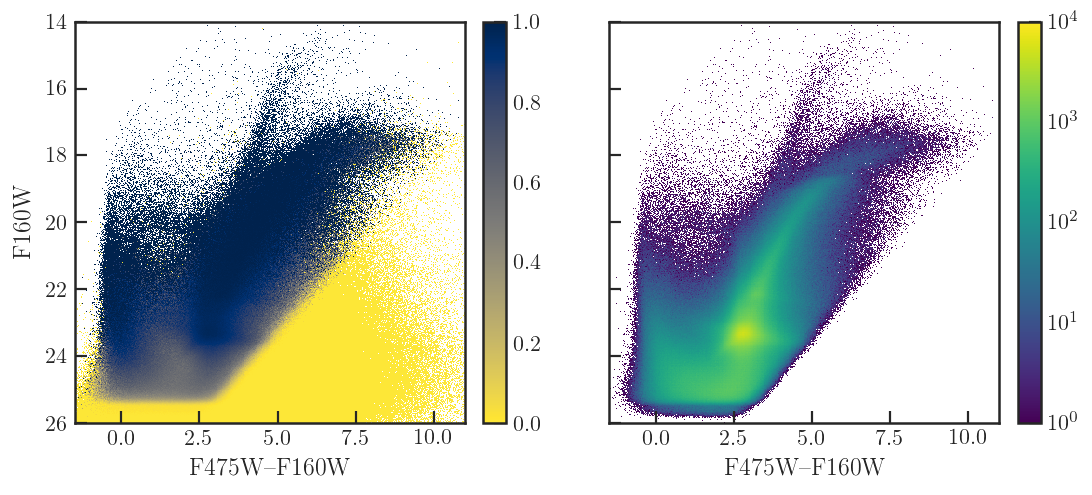

In [8]:
plot_frac_density(ds, 'F475W', 'F160W', [[-1.5, 11], [26, 14]])

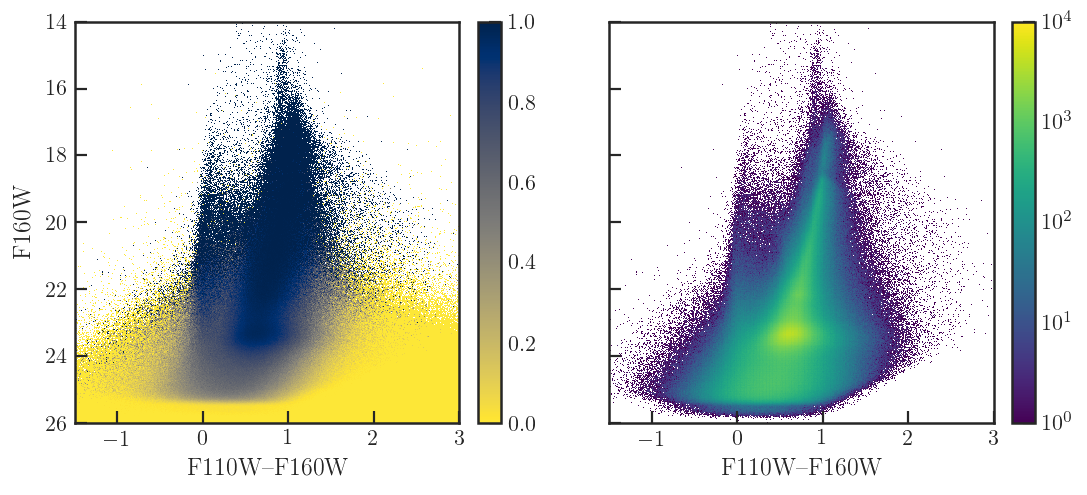

In [9]:
plot_frac_density(ds, 'F110W', 'F160W', [[-1.5, 3], [26, 14]])

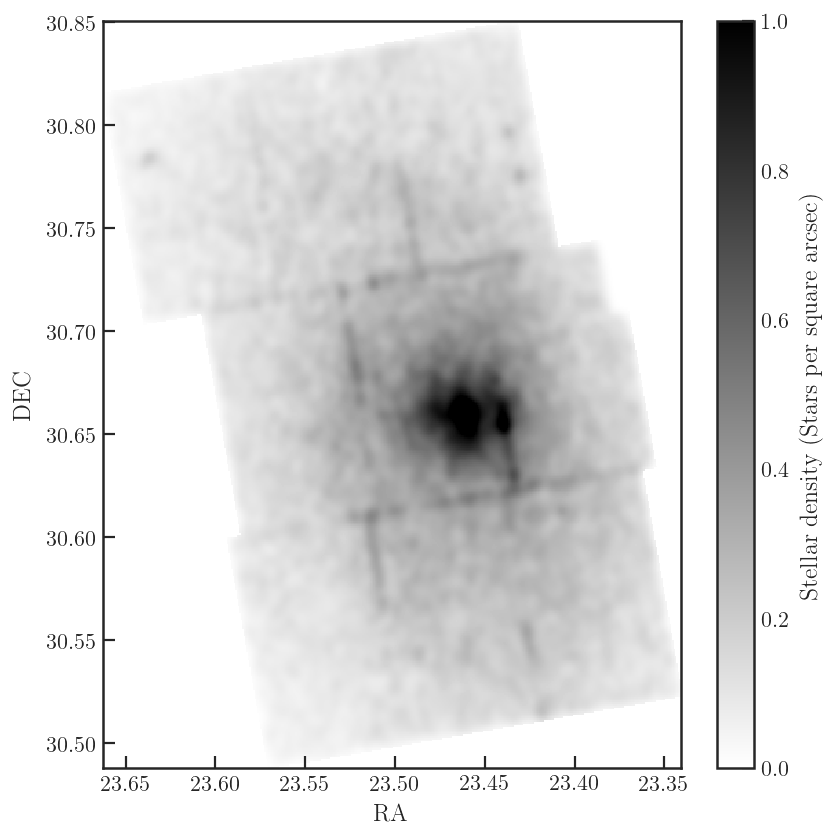

In [20]:
ds.plot('RA','DEC', what='mean(DENSITY)', figsize=(6,6),
        limits='minmax', shape=420, colormap='binary', vmin=0, vmax=1,
        colorbar_label='Stellar density (Stars per square arcsec)')
plt.gca().invert_xaxis()

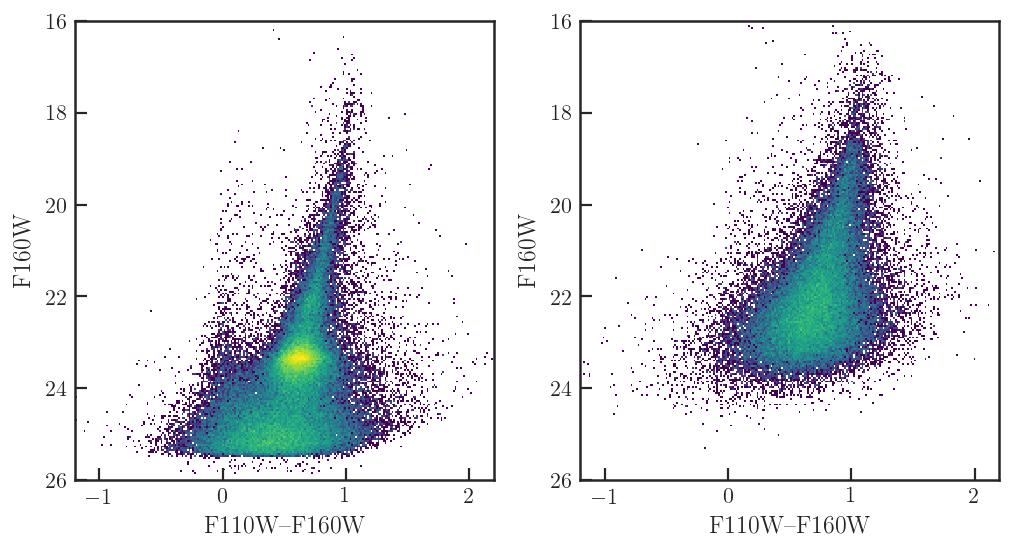

In [11]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(7.2, 4), sharex=True)

ir_lim = [[-1.2, 2.2], [26, 16]]

plt.sca(ax0)
ds.plot('F110W_VEGA-F160W_VEGA', 'F160W_VEGA', limits=ir_lim,
        f='log10', colorbar=False, colormap=colormap,
        vmin=np.log10(vmin), vmax=2, interpolation='None', shape=240,
        xlabel='F110W--F160W', ylabel='F160W', selection='IR_GST & (DENSITY < 0.05)')

plt.sca(ax1)
ds.plot('F110W_VEGA-F160W_VEGA', 'F160W_VEGA', limits=ir_lim,
        f='log10', colorbar=False, colormap=colormap,
        vmin=np.log10(vmin), vmax=2, interpolation='None', shape=240,
        xlabel='F110W--F160W', ylabel='F160W', selection='IR_GST & (DENSITY > 1)')



In [12]:
n_det = ds.evaluate('+'.join(ds.get_column_names(regex='F.*?W_ST_FLAG')))
if 'n_detected' in ds.get_column_names():
    ds.drop('n_detected', inplace=True)
ds.add_column('n_detected', n_det)

/astro/users/mdurbin/miniconda3/envs/astroconda/lib/python3.7/site-packages/vaex/image.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rgba_dest[:, :, c][[mask]] = np.clip(result[[mask]], 0, 1)


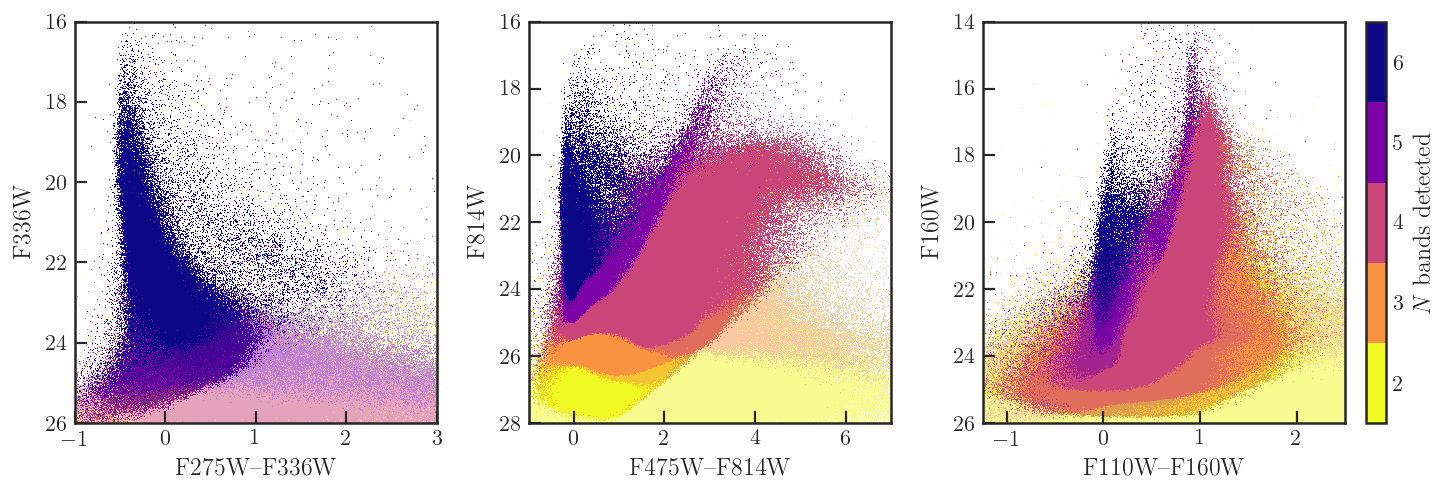

In [13]:
# W14 Fig [check]

colormap_frac, vmin_frac, vmax_frac = plt.cm.get_cmap('plasma_r', 5), 1.5, 6.5
cmap_frac = colormap_frac #getattr(mpl.cm, colormap_frac)
norm_frac = mpl.colors.Normalize(vmin_frac, vmax_frac)

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(9.6, 3.6))
ir_lim = [[-1.5, 3], [26,14]]

plt.sca(ax0)
ds.plot('F275W_VEGA-F336W_VEGA', 'F336W_VEGA', limits=[[-1, 3], [26, 16]],
        colormap=colormap_frac, colorbar=False, what=f'mean(n_detected)',
        vmin=vmin_frac, vmax=vmax_frac, interpolation='None', shape=420,
        xlabel='F275W--F336W', ylabel='F336W', selection=[None,'UV_GST'])

plt.sca(ax1)
ds.plot('F475W_VEGA-F814W_VEGA', 'F814W_VEGA', limits=[[-1, 7], [28, 16]],
        colormap=colormap_frac, colorbar=False, what=f'mean(n_detected)',
        vmin=vmin_frac, vmax=vmax_frac, interpolation='None', shape=420,
        xlabel='F475W--F814W', ylabel='F814W', selection=[None,'OPT_GST'])

plt.sca(ax2)
ds.plot('F110W_VEGA-F160W_VEGA', 'F160W_VEGA', limits=[[-1.25, 2.5], [26,14]],
        colormap=colormap_frac, colorbar=False, what=f'mean(n_detected)',
        vmin=vmin_frac, vmax=vmax_frac, interpolation='None', shape=420,
        xlabel='F110W--F160W', ylabel='F160W', selection=[None,'IR_GST'])

fig.tight_layout()

pos = ax2.get_position()
cax = fig.add_axes([pos.x1+0.015, pos.y0, 0.015, pos.height])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm_frac, cmap=cmap_frac), cax=cax, label='$N$ bands detected')

fig.savefig('survey_paper_figures/nbands_cmds.pdf', dpi=420, bbox_inches='tight')


<string>:1: RuntimeWarning: invalid value encountered in greater
/astro/users/mdurbin/miniconda3/envs/astroconda/lib/python3.7/site-packages/vaex/image.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rgba_dest[:, :, c][[mask]] = np.clip(result[[mask]], 0, 1)


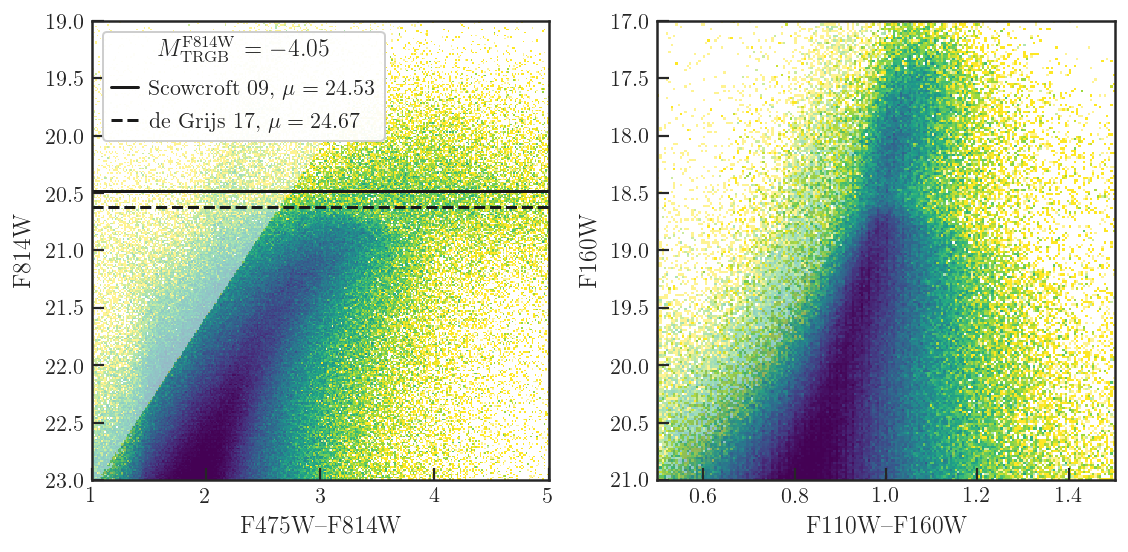

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

Mtrgb = -4.05
m, b = np.polyfit([1.5, 2.5], [22.5, 21.], 1)
good_rgb = f'(IR_ST & ~isfinite(F275W_VEGA) & (F814W_VEGA > {m}*(F475W_VEGA-F814W_VEGA)+{b}))'
ds.select(good_rgb, name='good_rgb')

plt.sca(ax1)
ds.plot('F475W_VEGA-F814W_VEGA-(0.135-0.063)', 'F814W_VEGA-0.063', limits=[[1, 5], [23, 19]],
        colormap='viridis_r', f='log10', colorbar=False,
        vmin=0, vmax=2, interpolation='None', shape=300,
        xlabel='F475W--F814W', ylabel='F814W', selection=['IR_ST','good_rgb'])
ax1.axhline(Mtrgb+24.53, color='k', label='Scowcroft 09, $\mu=24.53$')
ax1.axhline(Mtrgb+24.67, color='k', linestyle='--', label='de Grijs 17, $\mu=24.67$')
ax1.legend(title='$M^{\mathrm{F814W}}_{\mathrm{TRGB}} = '+f'{Mtrgb:.2f}$', loc='upper left')

plt.sca(ax2)
ds.plot('F110W_VEGA-F160W_VEGA', 'F160W_VEGA', limits=[[0.5, 1.5], [21, 17]],
        colormap='viridis_r', f='log10', colorbar=False,
        vmin=0, vmax=2, interpolation='None', shape=200,
        xlabel='F110W--F160W', ylabel='F160W', selection=['IR_ST','good_rgb'])

fig.tight_layout()



In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True)

    
custom_lines = [Line2D([0], [0], marker='.', color='k', ms=1000**0.5/10, lw=0, label='1000', alpha=0.5),
                Line2D([0], [0], marker='.', color='k', ms=5000**0.5/10, lw=0, label='5000', alpha=0.5),
                Line2D([0], [0], marker='.', color='k', ms=10000**0.5/10, lw=0, label='10000', alpha=0.5)]
ax1.legend(handles=custom_lines, title='Total RGB stars\n($20.3<\mathrm{F814W}<21.3$)')

x0, x1 = 20.3, 21.3
s1 = f'((F814W_VEGA >= {x0}-0.001) & (F814W_VEGA <= {x1}+0.001))'
for p in glob.glob('../legacy_phot/M33_B0?_??.phot.hdf5'):
    ds_ = open_and_select(p).dropna(column_names=['F814W_VEGA']).sort(by='F814W_VEGA')
    f814w = ds_.evaluate('F814W_VEGA', selection=f'({good_rgb}) & {s1}')
    n_tot = len(f814w)
    n_, be = np.histogram(f814w, bins=np.arange(x0, x1+0.025, 0.025), 
                          range=(x0, x1), density=True)
    bc = (be[:-1] + be[1:])/2
    ax1.plot(bc, n_, 'k.', ms=n_tot**0.5/10, alpha=0.3)
    f814w = f814w[(f814w >= x0) & (f814w <= x1)]
    f814w.sort()
    n = np.cumsum(np.ones_like(f814w)) / n_tot
    ax2.plot(f814w, n, 'k', alpha=np.clip(n_tot/1e4, 0.2, 1))
    ds_.close_files()

ax1.set_ylabel('Relative number')
ax2.set_ylabel('Cumulative fraction')
#ax1.set_ylim(0, 1)
ax2.set_ylim(0, 1)
ax1.set_xlim(x0, x1)
ax1.set_xlabel('F814W')
ax2.set_xlabel('F814W')

fig.tight_layout()
fig.savefig('survey_paper_figures/relative_lfs.pdf', bbox_inches='tight')

<string>:1: RuntimeWarning: invalid value encountered in greater
<string>:1: RuntimeWarning: invalid value encountered in greater
<string>:1: RuntimeWarning: invalid value encountered in greater
<string>:1: RuntimeWarning: invalid value encountered in greater
<string>:1: RuntimeWarning: invalid value encountered in greater
<string>:1: RuntimeWarning: invalid value encountered in greater
<string>:1: RuntimeWarning: invalid value encountered in greater
<string>:1: RuntimeWarning: invalid value encountered in greater
<string>:1: RuntimeWarning: invalid value encountered in greater
